In [1]:
%matplotlib inline

# To show model architecture, might need to install these
# !pip install pydot
# !pip install pydotplus
# !pip install graphviz
from tensorflow.keras.utils import plot_model

from typing import Tuple
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pickle as pk

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping


FORCE_TRAIN_MODELS = True


2022-08-21 10:37:19.279918: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-08-21 10:37:19.279955: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def process_image(filename: str) -> np.ndarray:
    '''
    Placeholder fucntion to process images, currently only reads from file, then resizes and grayscales.
    '''
    # Smallest size in dataset is 147x147
    img = cv2.imread("../../data/images/"+filename)
    return cv2.cvtColor(cv2.resize(img, (100,100)), cv2.COLOR_BGR2GRAY)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Greens, save_to_file = False):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (16,16))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save_to_file:
        plt.savefig('Assets/files/' + title + '.pdf')
    return ax

In [3]:
LOAD_DB = False
if LOAD_DB:
    df = pd.read_csv("../../data/metadata.csv")[["diagnostic", "img_id"]].rename({"diagnostic": "y", "img_id":"x_name"}, axis=1)
    df["y2"] = df["y"].apply(lambda x:"CANCER" if x in ["MEL", "BCC", "SCC"] else "NOT CANCER") #Separate Cancer from Not-Cancer
    df["x"] = df["x_name"].apply(process_image)
    with open("db_cache.pickle", "wb") as fl:
        pk.dump(df, fl)
else:
    with open("db_cache.pickle", "rb") as fl:
        df = pk.load(fl)
df

,y,x_name,y2,x
0,NEV,PAT_1516_1765_530.png,NOT CANCER,"[[115, 113, 118, 115, 116, 114, 113, 113, 115,..."
1,BCC,PAT_46_881_939.png,CANCER,"[[148, 151, 151, 148, 152, 151, 168, 152, 151,..."
2,ACK,PAT_1545_1867_547.png,NOT CANCER,"[[172, 164, 186, 192, 190, 179, 181, 166, 153,..."
3,ACK,PAT_1989_4061_934.png,NOT CANCER,"[[192, 200, 193, 194, 190, 180, 180, 181, 190,..."
4,BCC,PAT_684_1302_588.png,CANCER,"[[108, 110, 116, 117, 126, 122, 123, 123, 123,..."
...,...,...,...,...
2293,ACK,PAT_1708_3156_175.png,NOT CANCER,"[[92, 96, 101, 97, 100, 102, 96, 96, 126, 130,..."
2294,BCC,PAT_46_880_140.png,CANCER,"[[178, 178, 177, 177, 172, 175, 181, 182, 172,..."
2295,SEK,PAT_1343_1217_404.png,NOT CANCER,"[[168, 169, 212, 160, 172, 177, 180, 178, 167,..."
2296,BCC,PAT_326_690_823.png,CANCER,"[[124, 124, 118, 115, 115, 115, 114, 116, 119,..."


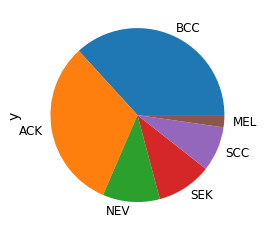

In [4]:
df["y"].value_counts().plot.pie();

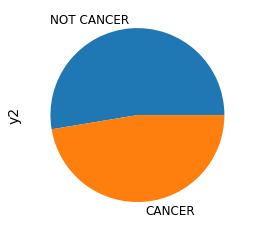

In [5]:
df["y2"].value_counts().plot.pie();

In [6]:
MulticlassEnconder = OneHotEncoder(sparse=False)
BinaryClassEnconder = OneHotEncoder(sparse=False)
X = np.array(df["x"])
X = np.array([X[i] for i in range(len(X))]) # Reshape
Y = MulticlassEnconder.fit_transform(df[["y"]])
Y_binary = BinaryClassEnconder.fit_transform(df[["y2"]])

In [7]:
# Examples of data
print("\nY is a 2D array where each column represents a class, and each row represents a datapoint. 0 indicates that the data is not of this class, and 1 indicates it is.")
print("Sample Y")
print(Y[0], "Shape={}".format(Y[0].shape))
print("Decoded Sample Y")
print(MulticlassEnconder.inverse_transform([Y[0]]))
print("")

print("X is an array where each item is a 147x147 grayscale picture.")
print("Sample X")
print(X[0])
print("Sample X is of shape {}\n".format(X[0].shape))

print("Y_binary is a 2D array similar to Y, however classes were grouped in such a way as to reduce number of classes.")
print("Sample Y")
print(Y_binary[0])
print("Decoded Sample Y_binary")
print(BinaryClassEnconder.inverse_transform([Y_binary[0]]))



Y is a 2D array where each column represents a class, and each row represents a datapoint. 0 indicates that the data is not of this class, and 1 indicates it is.
Sample Y
[0. 0. 0. 1. 0. 0.] Shape=(6,)
Decoded Sample Y
[['NEV']]

X is an array where each item is a 147x147 grayscale picture.
Sample X
[[115 113 118 ... 121 112 119]
 [115 113 116 ... 120 118 115]
 [115 112 113 ... 119 119 118]
 ...
 [148 143 147 ...  75  75  67]
 [146 148 146 ...  70  71  63]
 [152 144 140 ...  66  62  47]]
Sample X is of shape (100, 100)

Y_binary is a 2D array similar to Y, however classes were grouped in such a way as to reduce number of classes.
Sample Y
[0. 1.]
Decoded Sample Y_binary
[['NOT CANCER']]


In [8]:
# Used to discover minimum size to equalize dataset
# w = []
# h = []
# for i in X:
#     w.append(i.shape[0])
#     h.append(i.shape[1])
# min_w = min(w)
# min_h = min(h)
# print(min_w, min_h)

In [12]:
def model_run(X: np.ndarray, Y: np.ndarray) -> Tuple[keras.callbacks.History, np.ndarray, np.ndarray, keras.models.Sequential]:
    '''
    Function to encompass data splitting and model training. Meant to allow for different preprocessed datasets to be used interchangeably.
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

    input_shape=(X_train[0].shape[0], X_train[0].shape[1], 1)
    no_classes = y_train[0].shape[0]
    
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(7, 7), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(no_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy())    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=1000, batch_size=150, validation_data=(X_valid, y_valid), callbacks=es, verbose=0)
    y_pred = model.predict(X_test)
    
    return history, y_test, y_pred, model

def show_results(model: Sequential, history: keras.callbacks.History, y_test: np.ndarray, y_pred: np.ndarray, encoder: OneHotEncoder, cache_img_filename="cache.png") -> plt.figure:
    plot_model(model, show_shapes=True, show_layer_activations=True, to_file=cache_img_filename)
    fig = plt.figure(figsize=(10,30))
    
    ax = fig.add_subplot(121)
    ax.imshow(cv2.imread(cache_img_filename)[:,:,::-1])
    ax.axis('off')

    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.xlabel("Epochs")
    plt.ylabel("Categorical Crossentropy (loss)")
    plt.ylim((0,10))
    plt.title("Model History")
    plt.show()
    print("Examples of predictions:\n {}".format(y_pred[:3]))
    y_pred_classes = encoder.inverse_transform(y_pred)
    ax = plot_confusion_matrix(y_true=encoder.inverse_transform(y_test), y_pred=y_pred_classes, classes=list(set(y_test.flatten())))
    fig.axes.append(ax)

    return fig

2022-08-21 10:37:22.277907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 10:37:22.278363: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cedip/.local/lib/python3.8/site-packages/cv2/../../lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-08-21 10:37:22.278443: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cedip/.local/lib/python3.8/site-packages/cv2/../../lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-08-21 10:37:22.278516: W tensorflow/stream_executor/platform/default/ds

Restoring model weights from the end of the best epoch: 39.
Epoch 69: early stopping
15/15 [==============================] - 1s 66ms/step


INFO:tensorflow:Assets written to: multiclass_cnn/assets


INFO:tensorflow:Assets written to: multiclass_cnn/assets


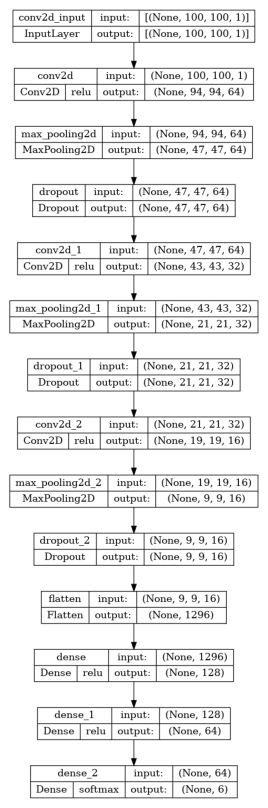

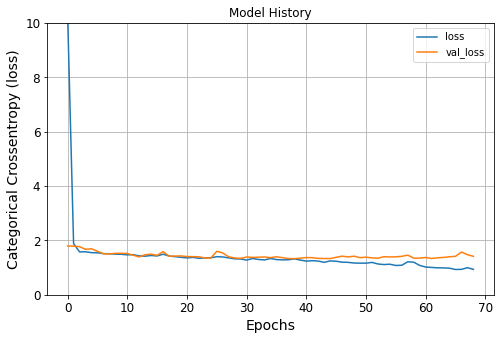

Examples of predictions:
 [[1.8067141e-01 5.2025306e-01 1.1378479e-02 9.4633982e-02 4.9666580e-02
  1.4339648e-01]
 [4.2969114e-01 4.7765332e-01 7.6744636e-06 4.1957074e-03 7.9653695e-02
  8.7983701e-03]
 [1.5918542e-02 5.7924080e-01 4.0281639e-03 3.2321092e-01 4.8857436e-02
  2.8744118e-02]]


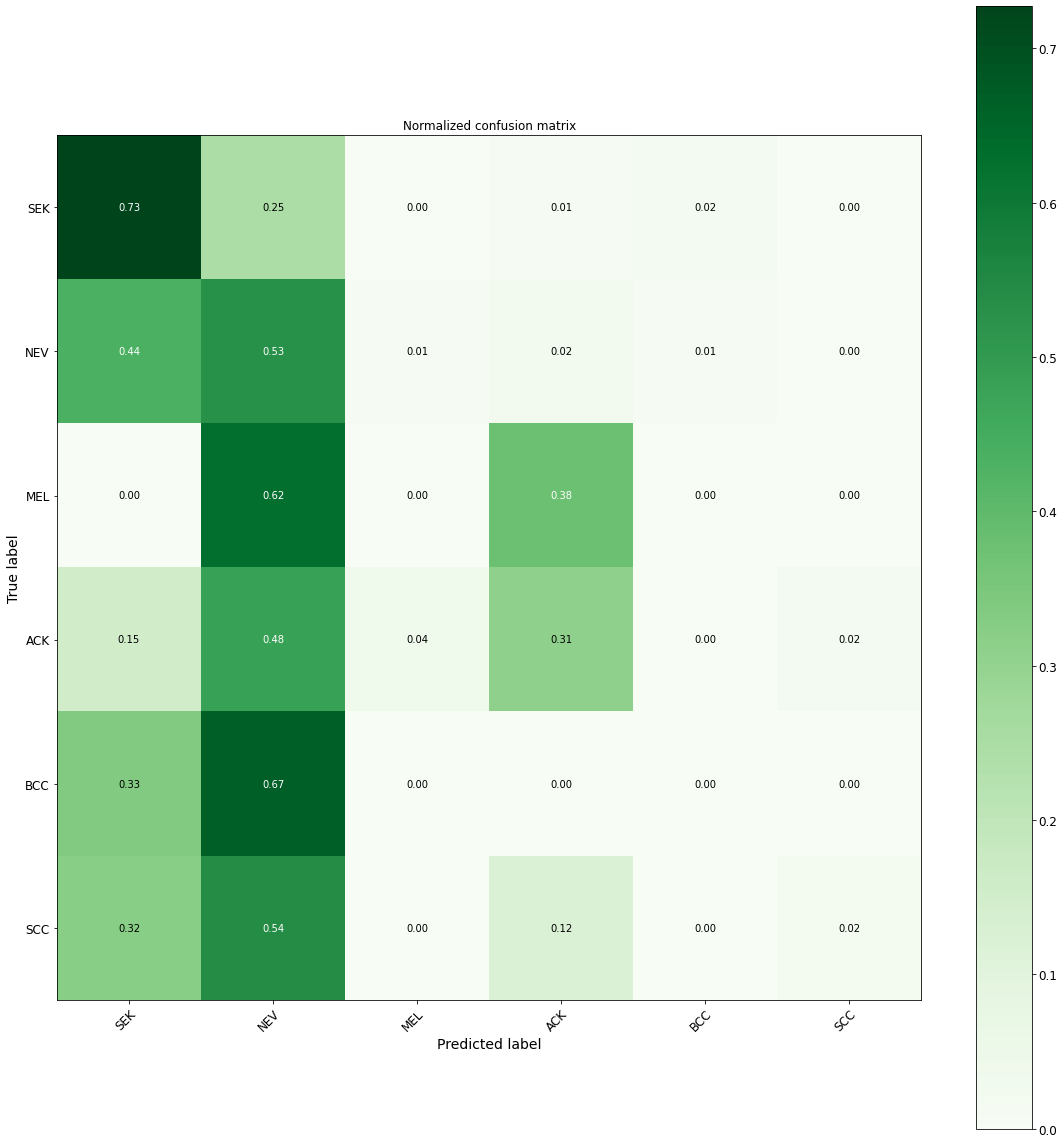

In [10]:
if FORCE_TRAIN_MODELS:
    history, y_test, y_pred, model = model_run(X,Y)
    model.save("multiclass_cnn")
    show_results(model, history, y_test, y_pred, MulticlassEnconder, "cnn_simple_multiclass.png")

Restoring model weights from the end of the best epoch: 13.
Epoch 43: early stopping
15/15 [==============================] - 1s 66ms/step


INFO:tensorflow:Assets written to: binary_cnn/assets


INFO:tensorflow:Assets written to: binary_cnn/assets


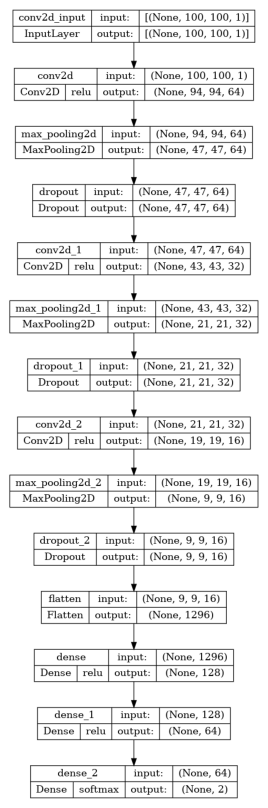

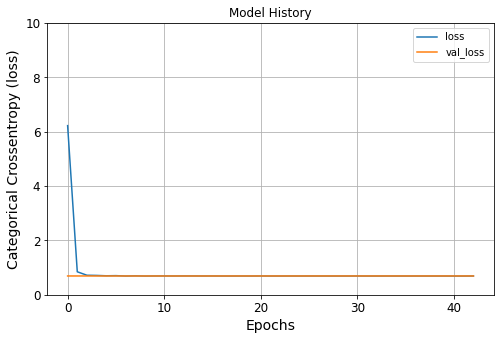

Examples of predictions:
 [[0.47836784 0.5216321 ]
 [0.47836784 0.5216321 ]
 [0.47836784 0.5216321 ]]


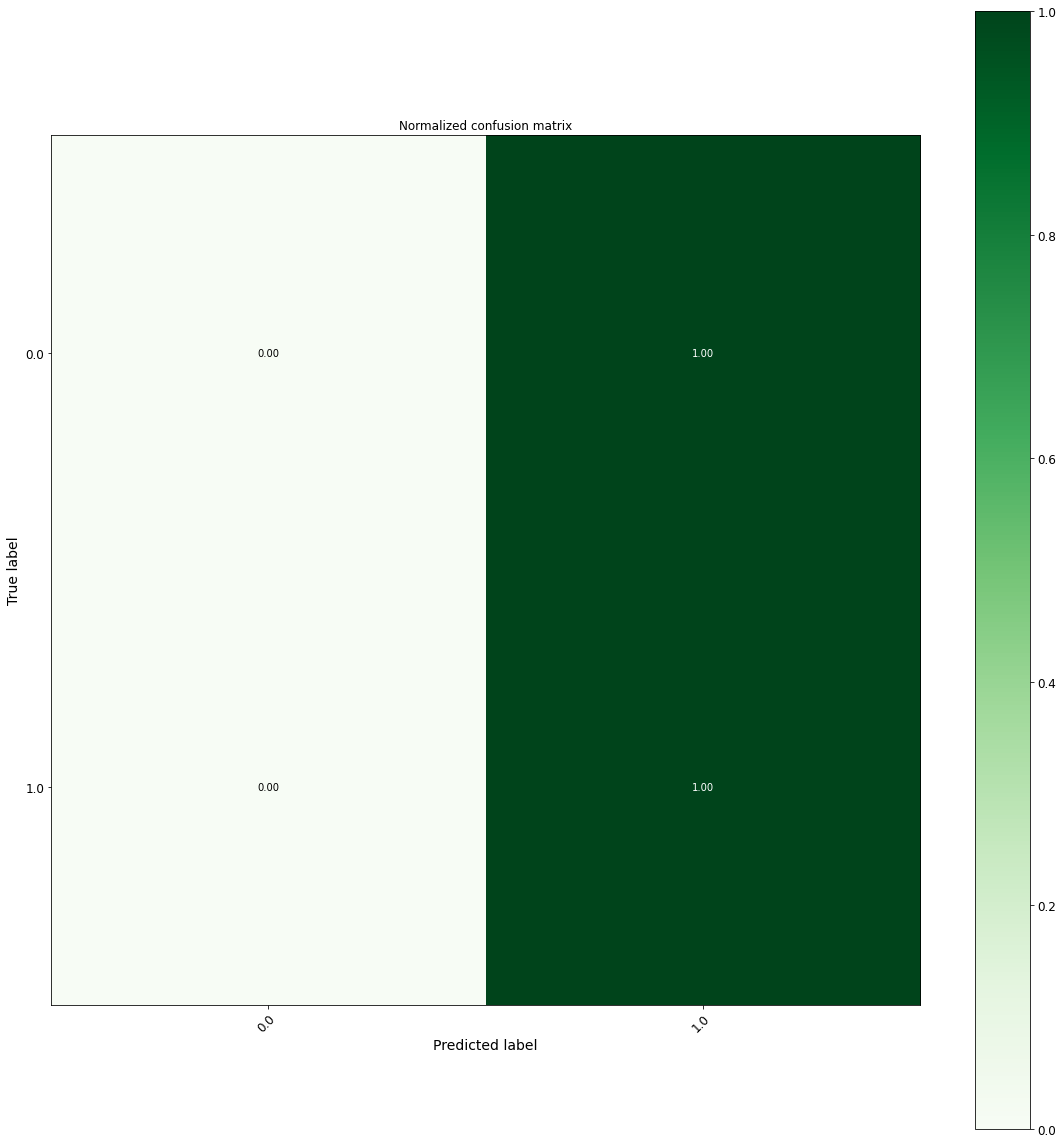

In [13]:
if FORCE_TRAIN_MODELS:
    history, y_test, y_pred, model = model_run(X,Y_binary)
    model.save("binary_cnn")
    show_results(model, history, y_test, y_pred, BinaryClassEnconder, "cnn_simple_binary.png")